# Distance Comparison between Google Distance Matrix API and Haversine (as the crow flies)

## Preprocessing Steps

Importing python modules and getting API key

In [1]:
from sklearn.neighbors import NearestNeighbors
import geopandas as gp
import numpy as np
import os
import googlemaps
import matplotlib.pyplot as plt

gp.pd.options.display.max_rows = 10

apikey = os.getenv('GOOGLE_MAP_API_KEY')
gmaps  = googlemaps.Client(apikey)

Read in shapefile

In [2]:
wdir = r'X:\MS2'
ma = gp.read_file(os.path.join(wdir,'Mhd2017Export.shp'))

Iterate through each geometry and choose an arbitrary point to represent the road segment. Here I chose the first point in the linestring.

In [3]:
geom = []
for row in ma.itertuples():
    if row.geometry.type == 'LineString':
        geom.append(row.geometry.coords[0])
    elif row.geometry.type == 'MultiLineString':
        for linestring in row.geometry:
            geom.append(linestring.coords[0])
            break
ma['pt'] = geom

Choosing a subsample to compare. Here I choose based on county. I choose Berkshire county because it borders both the northern and southern boundary of Massachusetts.

In [4]:
county = ma[(ma['COUNTY'] == '3')]
county.reset_index(drop=True, inplace=True)

Use the nearest neighbor algorithm to find the closest `k` neighbors for each road segment. It returns the neighbor id (row number) along with the corresponding haversine distance. We multiply it by Earth's radius to get it in the appropriate unit.

In [5]:
XY = county['pt'].tolist()
XY = [[pt[1],pt[0]] for pt in XY] # latitutde,longitude format 
xy = np.radians(XY)
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto', leaf_size=30, metric='haversine')
nbrs.fit(xy)
distances, nid = nbrs.kneighbors(xy)
R = 6371 # avg Earth radius in km
distances *= R

In [6]:
nid

array([[   0,   23,   24, ..., 2776,  927, 2608],
       [   1,  926,  927, ..., 3141, 2820,   13],
       [   2,  928,  927, ..., 2706, 2516, 2821],
       ..., 
       [3220, 2936, 2927, ...,  143,  176,  177],
       [3221, 2928, 3222, ..., 2987, 2980, 3214],
       [3222, 2948, 2928, ..., 2987, 2980, 3214]], dtype=int64)

In [7]:
distances

array([[ 0.        ,  0.11624839,  0.14769209, ...,  0.79839008,
         0.80492603,  0.8175712 ],
       [ 0.        ,  0.12335718,  0.16070397, ...,  0.59028603,
         0.59220125,  0.59401006],
       [ 0.        ,  0.1044344 ,  0.15796374, ...,  0.45832769,
         0.4823994 ,  0.4892717 ],
       ..., 
       [ 0.        ,  0.08251677,  0.14064991, ...,  0.9275115 ,
         0.93867396,  0.95895518],
       [ 0.        ,  0.02395408,  0.05064373, ...,  1.07913732,
         1.39614578,  1.43711027],
       [ 0.        ,  0.00658318,  0.02681579, ...,  1.12675085,
         1.34878615,  1.38973484]])

For each road segment, choose a random neighbor to construct an origin-destination (O-D) pair. Construct a dataframe from the O-D pairs and remove any duplicates. Set random seed for reproducibility.

In [8]:
count = 0
np.random.seed(2018)
OD = []
for origin in range(county.shape[0]):
    choice = np.random.randint(1,k,1)[0]
    dest = nid[origin][choice]
    dist = distances[origin][choice] * 1000
    if origin < dest:
        OD.append((origin,dest,choice,dist))
    else:
        OD.append((dest,origin,choice,dist))
    if dist < 0.001:
        count += 1
        
df = gp.pd.DataFrame(OD, columns=['origin','dest','n_neighbor','crow']).drop_duplicates(['origin','dest'])

Sample the dataframe so we are within the daily Google API rate limit of 2500 O-D pairs.

In [9]:
sample = df.sample(n=2400).sort_values(['origin','dest']).reset_index(drop=True)

Iterate through the dataframe and make a request to the Google Distance Matrix API. Construct a dataframe from this data and save the data to a file for future reference. 

In [10]:
api_flag = False
if api_flag:
    coords = []
    for row in sample.itertuples():
        origin = '{:.6f},{:.6f}'.format(XY[row.origin][0],XY[row.origin][1])
        dest = '{:.6f},{:.6f}'.format(XY[row.dest][0],XY[row.dest][1])
        R = gmaps.distance_matrix(origins=origin, destinations=dest)
        distance = R['rows'][0]['elements'][0]['distance']['value']
        coords.append((XY[row.origin],XY[row.dest],distance))
    driving = gp.pd.DataFrame(coords, columns=['origin','dest','goog'])
    driving.to_csv('google_distance_matrix.csv', index=False, sep='|')
else:
    driving = gp.pd.read_csv('google_distance_matrix.csv', sep='|')

Combine the two datasets (haversine and google) and calculate the difference.

In [11]:
sample['goog'] = driving['goog']
sample['delta'] =  sample['goog'] - sample['crow']
sample.sort_values('delta', inplace=True)

## Descriptive Statistics

Here is the dataframe that contains the relevant data. 

* origin, dest - contains row id of segment
* n_neighbor - nth closest neighbor to segment
* crow, goog - distance btw O-D pair for haversine and google API respectively
* delta - difference between the two metrics

Note: Distances are in meters for columns crow, goog, and delta.

In [12]:
sample

,origin,dest,n_neighbor,crow,goog,delta
142,116,219,10,672.525865,668,-4.525865
639,550,1553,3,75.325174,72,-3.325174
1975,2285,2286,8,207.228675,204,-3.228675
715,601,1921,4,209.212445,206,-3.212445
271,222,249,3,355.083549,352,-3.083549
...,...,...,...,...,...,...
2275,2757,3031,17,2672.684762,31016,28343.315238
1969,2267,2497,7,1741.407797,30912,29170.592203
2087,2499,2916,15,1441.316883,32476,31034.683117
514,454,2491,17,2861.271057,36536,33674.728943


In [13]:
sample['delta'].describe([0.75,0.9,0.95,0.99])

count     2400.000000
mean       706.100946
std       2836.276653
min         -4.525865
50%         71.719718
75%        331.092314
90%       1195.414122
95%       2546.184654
99%      17596.912272
max      36693.419358
Name: delta, dtype: float64

## Comparison between Google and Haversine

## Figure 1: Google vs Haversine

C:\Users\caoa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(6,1,'y=x')

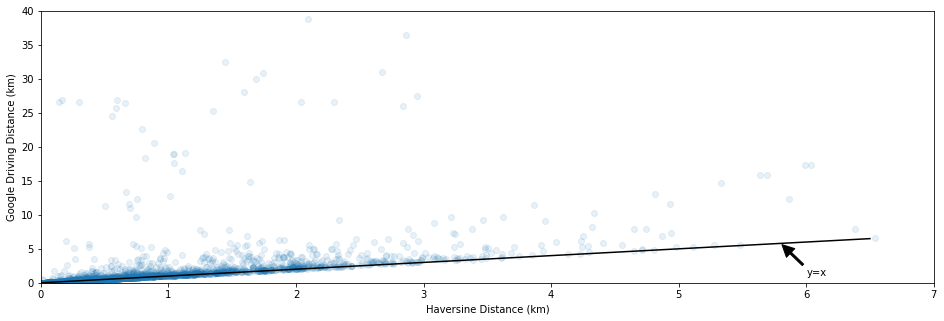

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(16,5))
plt.scatter(sample['crow']/1000, sample['goog']/1000,alpha=0.1)
plt.xlabel('Haversine Distance (km)')
plt.ylabel('Google Driving Distance (km)')
xy = [0,6.500]
plt.plot(xy,xy,'k')
ax = fig.add_subplot(111)
plt.xlim([0, 7]); plt.ylim([0, 40])
params = {'width':2,
          'shrink': 0.05,
          'facecolor':'black'}
ax.annotate('y=x', xy=(5.8,5.8), xytext=(6,1), arrowprops=params)

Let's look at a couple of examples for the large deltas.

In [15]:
sample.tail()

,origin,dest,n_neighbor,crow,goog,delta
2275,2757,3031,17,2672.684762,31016,28343.315238
1969,2267,2497,7,1741.407797,30912,29170.592203
2087,2499,2916,15,1441.316883,32476,31034.683117
514,454,2491,17,2861.271057,36536,33674.728943
1232,1203,2417,13,2097.580642,38791,36693.419358


## Example 1: Freeway Segment

In [16]:
print(XY[1203], XY[2417])

[42.25180422900007, -73.03956206299995] [42.23796716600003, -73.05688164999998]


Google Map Directions for this O-D pair. Issue is that the destination segment is eastbound so the directions has to find the nearest on-ramp in the EB direction.

![gmaps1](img/distance_comparison1.png)

## Example 2: Another Freeway Segment

In [17]:
print(XY[2499], XY[2916])

[42.34144445000004, -73.39379061699998] [42.35252574200007, -73.38469198599995]


This time, there is no nearby off-ramp to the destination so a circuitous route is required.

![gmaps2](img/distance_comparison2.png)

So the common theme appears to be is that if one of the OD pairs is a freeway segment, then you are likely to have considerable longer driving distances than haversine. Also, of note, is that reverse directions would also give a substantially different answer also.

What if we removed the road segments with FCC value of 1 and 2 from the dataset?

In [18]:
freeways = county[county['FUNCCODE'].isin(['1','2'])]
idx = set(freeways.index)
tf = (sample['origin'].isin(idx)) | (sample['dest'].isin(idx))
F36 = sample[~tf]

## Figure 2: Google vs Haversine excluding FCC codes 1 and 2

C:\Users\caoa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(6,1,'y=x')

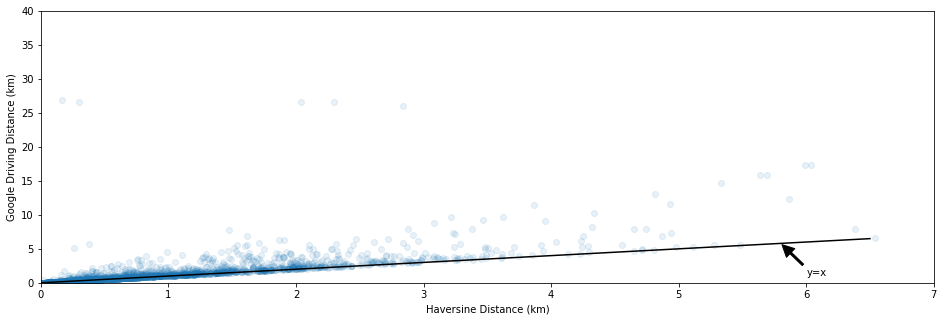

In [19]:
fig = plt.figure(figsize=(16,5))
plt.scatter(F36['crow']/1000, F36['goog']/1000,alpha=0.1)
plt.xlabel('Haversine Distance (km)')
plt.ylabel('Google Driving Distance (km)')
xy = [0,6.500]
plt.plot(xy,xy,'k')
ax = fig.add_subplot(111)
plt.xlim([0, 7]); plt.ylim([0, 40])
params = {'width':2,
          'shrink': 0.05,
          'facecolor':'black'}
ax.annotate('y=x', xy=(5.8,5.8), xytext=(6,1), arrowprops=params)

Let's see what's going on with our worst offenders again. There seems to be two class of discrepancies based on the figure and the columns `delta` and  `n_neighbor`. The bottom five fall into one class and the next 5 fall into a different class of problems.

In [20]:
F36.tail(10)

,origin,dest,n_neighbor,crow,goog,delta
1226,1190,2760,19,5331.533066,14695,9363.466934
393,336,2593,18,5696.087499,15829,10132.912501
488,439,2592,16,5637.509696,15922,10284.490304
753,628,814,14,6041.023157,17285,11243.976843
754,629,814,14,5988.336124,17358,11369.663876
1896,2127,3124,8,2834.782151,26001,23166.217849
1816,1961,2811,9,2296.415740,26673,24376.584260
1897,2128,2652,7,2035.037385,26604,24568.962615
1332,1346,3171,7,300.541766,26577,26276.458234
44,46,3171,2,161.252246,26885,26723.747754


## Example 3: Freeway Segment

In [21]:
print(XY[46], XY[3171])

[42.328109753000035, -73.36298205699995] [42.32730243800006, -73.36461153199997]


The problem is that the destination is still on a freeway segment and heading westbound but before the on-ramp to the highway.

![gmaps3](img/distance_comparison3.png)

Let's look at its FUNCCODE of the destination to make sure we're not hallucinating. It has code 5. 

In [22]:
county.loc[3171,['FUNCCODE','pt'] ]

FUNCCODE                                          5
pt          (-73.36461153199997, 42.32730243800006)
Name: 3171, dtype: object

Not sure if we can do anything to avoid this situation. If we reverse directions, then the distance would definitely be a lot shorter.

## Example 4: Shortest Time Route

In [23]:
print(XY[629], XY[814])

[42.11620711100005, -73.49637794099993] [42.154813696000076, -73.44574458599999]


This seems to be a function of the road network but also google's preference for shortest time. There is a shorter distance route that it could have given. Unfortunately, there is no way to specify this constraint in the call to the API.

![gmaps4](img/distance_comparison4.png)

## Example 5: Another Shortest Time Route

In [24]:
print(XY[439], XY[2592])

[42.048620276000065, -73.12225781699993] [42.08375019500005, -73.07301614799997]


Same problem here. Google chose the shortest time path instead of the shortest distance path. 

![gmaps5](img/distance_comparison5.png)

# Summary

Differences in distance are attributable to the following factors:
1. O-D pair contains a freeway segment.
2. Google API chooses the shortest time path by default rather than the shortest distance path.